In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random
import math

import seaborn # Attention 시각화를 위해 필요!

print(torch.__version__)

2.7.1+cu118


In [4]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = nn.Linear(d_model, d_model)  # Linear Layer
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = K.size(-1)
        QK = torch.matmul(Q, K.transpose(-2, -1))

        scaled_qk = QK / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        if mask is not None:
            scaled_qk += (mask * -1e9)

        attentions = F.softmax(scaled_qk, dim=-1)
        out = torch.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)

        return x

    def combine_heads(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 2, 1, 3)
        x = x.contiguous().view(batch_size, -1, self.d_model)

        return x

    def forward(self, Q, K, V, mask=None):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [6]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.w_1(x))
        out = self.w_2(out)

        return out

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_3 = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, causality_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [9]:
class Encoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

    def forward(self, x, mask):
        out = x
        enc_attns = []

        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [10]:
class Decoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

    def forward(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = []
        dec_enc_attns = []
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
                self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [11]:
class Transformer(nn.Module):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = float(d_model)

        self.enc_emb = nn.Embedding(src_vocab_size, d_model)
        self.dec_emb = nn.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = self.positional_encoding(pos_len, d_model)
        self.dropout = nn.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = nn.Linear(d_model, tgt_vocab_size)

        self.shared = shared
        if shared:
            self.fc.weight = self.dec_emb.weight

    def positional_encoding(self, pos_len, d_model):
        position = torch.arange(0, pos_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        pos_encoding = torch.zeros(pos_len, d_model)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding

    def embedding(self, emb, x):
        seq_len = x.size(1)
        out = emb(x)

        if self.shared:
            out *= torch.sqrt(torch.tensor(self.d_model))

        out += self.pos_encoding[:seq_len, :].unsqueeze(0)
        out = self.dropout(out)

        return out

    def forward(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
            self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [12]:
import torch
import numpy as np

def generate_padding_mask(seq):
    mask = (seq == 0).float()
    return mask.unsqueeze(1).unsqueeze(2)

def generate_causality_mask(size):
    """Causal Mask 생성 (Upper triangular matrix)"""
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(tgt)
    seq_len = tgt.shape[-1]
    causal_mask = generate_causality_mask(seq_len)
    batch_size = src.shape[0]
    dec_mask = causal_mask.expand(batch_size, 1, seq_len, seq_len)

    return enc_mask, dec_enc_mask, dec_mask

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

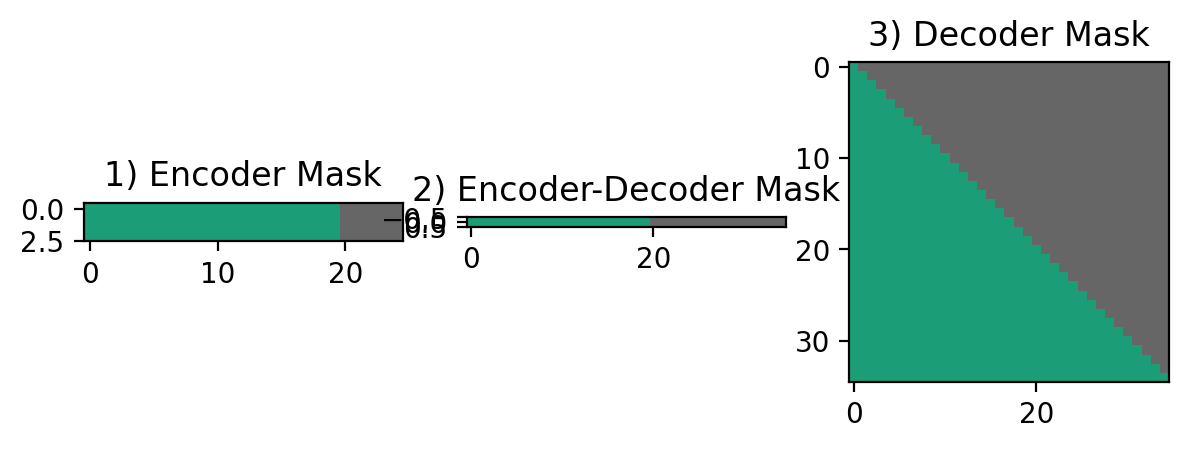

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = torch.zeros((batch, src_padding))
tgt_pad = torch.zeros((batch, tgt_padding))

sample_data = torch.ones((batch, length))
sample_src = torch.cat([sample_data, src_pad], dim=-1)
sample_tgt = torch.cat([sample_data, tgt_pad], dim=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [14]:
class LearningRateScheduler:
    def __init__(self, d_model, warmup_steps=4000):
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = torch.tensor(step, dtype=torch.float32)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * torch.minimum(arg1, arg2)

model = nn.Linear(10, 10)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-9,
    betas=(0.9, 0.98),
    eps=1e-9)